In [1]:
import pandas as pd
import numpy as np
from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


from sklearn import metrics
from sklearn import preprocessing
from scipy.stats import shapiro

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

pd.set_option('display.max_rows', None)  # Muestra todas las filas
pd.set_option('display.max_columns', None)  # Muestra todas las columnas
pd.set_option('display.float_format', '{:.2f}'.format)  # Cambia 2 a la cantidad de decimales que desees mostrar

df = pd.read_csv('data_w.csv')
tabla = pd.DataFrame(df)
tabla.head()

,Año,Poblacion,Extension,Densidad_C,Pobl_Urbana,Porcentaje_Urbano,Tierras_Cultivables,Area_Selvatica,Refugiados_P_Origen,Porcentaje_Refugiados,Emisiones_N2O,Emisiones_CO2,Temperatura_Media,Cambio_Temperatura,Precipitaciones,Porcent_Hielo,Radiacion_solar_w/m2
0,1960,3021222521.00,131091936.64,23.05,1017560391.00,33.68,1241680080.30,0.00,150000.00,0.00,0.00,0.00,18.08,0.00,0.01,0.05,0.05
1,1961,3061799463.00,131091936.64,23.36,1046103392.00,34.17,1241680080.30,0.00,302000.00,0.01,0.00,0.00,18.22,0.00,0.01,-0.09,-0.09
2,1962,3115847136.00,131091936.64,23.77,1077961218.00,34.60,1242475597.30,0.00,322000.00,0.01,0.00,0.00,18.31,0.00,-0.01,-0.11,-0.11
3,1963,3182036754.00,131091936.64,24.27,1112782604.00,34.97,1249803780.40,0.00,353000.00,0.01,0.00,0.00,18.36,0.00,0.02,-0.02,-0.02
4,1964,3248650390.00,131091936.64,24.78,1148487944.00,35.35,1252095628.90,0.00,1700690.00,0.05,0.00,0.00,17.99,0.00,-0.01,0.05,0.05


In [2]:
# Existen algunas variables con datos desde hace menos años. Hacemos una proyección de ellos hacia el pasado.

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge


# Datos históricos de población
hist_selva = tabla.iloc[30:][['Año', 'Area_Selvatica']]
hist_N2O = tabla.iloc[30:][['Año', 'Emisiones_N2O']]
hist_CO2 = tabla.iloc[30:45][['Año', 'Emisiones_CO2']]
hist_camb_temp = tabla.iloc[10:][['Año', 'Cambio_Temperatura']]

# Modelo de regresión lineal Ridge
alpha = 1.0  # Valor ajustable

model_selva = Ridge(alpha=alpha)
model_N2O = Ridge(alpha=alpha)
model_CO2 = Ridge(alpha=alpha)
model_camb_temp = Ridge(alpha=alpha)

# Ajusta el modelo a los datos históricos
X = hist_selva[['Año']]
y = hist_selva['Area_Selvatica']
model_selva.fit(X, y)

V = hist_N2O[['Año']]
w = hist_N2O['Emisiones_N2O']
model_N2O.fit(V, w)

S = hist_CO2[['Año']]
t = hist_CO2['Emisiones_CO2']
model_CO2.fit(S, t)

P = hist_camb_temp[['Año']]
q = hist_camb_temp['Cambio_Temperatura']
model_camb_temp.fit(P, q)

# Proyecta las variables al pasado
pas_años_selva = np.arange(1960, 1991)
selva_pas = model_selva.predict(pas_años_selva.reshape(-1, 1))

pas_años_N2O = np.arange(1960, 1991)
N2O_pas = model_N2O.predict(pas_años_N2O.reshape(-1, 1))

pas_años_CO2 = np.arange(1960, 1991)
CO2_pas = model_CO2.predict(pas_años_CO2.reshape(-1, 1))

pas_años_camb_temp = np.arange(1960, 1991)
camb_temp_pas = model_camb_temp.predict(pas_años_camb_temp.reshape(-1, 1))


# Crea un DataFrame para los datos proyectados
datos_proyectados_pas = pd.DataFrame({'Año': pas_años_selva, 'Area_Selvatica': selva_pas,
'Año': pas_años_N2O, 'Emisiones_N2O': N2O_pas,
'Año': pas_años_CO2, 'Emisiones_CO2': CO2_pas,
'Año': pas_años_camb_temp, 'Cambio_Temperatura': camb_temp_pas})

datos_proyectados_pas.head()

/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Ridge was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Ridge was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Ridge was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Ridge was fitted with feature names
  warnings.warn(


,Año,Area_Selvatica,Emisiones_N2O,Emisiones_CO2,Cambio_Temperatura
0,1960,43919617.62,102071399.64,706.62,-0.46
1,1961,43860097.71,102265928.73,709.25,-0.43
2,1962,43800577.81,102460457.81,711.87,-0.40
3,1963,43741057.90,102654986.90,714.50,-0.37
4,1964,43681538.00,102849515.98,717.12,-0.34


In [3]:
# Rellena la tabla original con los datos proyectados hacia el pasado.

tabla.loc[0:29,'Area_Selvatica'] = datos_proyectados_pas.loc[0:29,'Area_Selvatica']
tabla.loc[0:29,'Emisiones_N2O'] = datos_proyectados_pas.loc[0:29,'Emisiones_N2O']
tabla.loc[0:29,'Emisiones_CO2'] = datos_proyectados_pas.loc[0:29,'Emisiones_CO2']
tabla.loc[0:9,'Cambio_Temperatura'] = datos_proyectados_pas.loc[0:9,'Cambio_Temperatura']


In [4]:
tabla.head()
# tabla.info()

,Año,Poblacion,Extension,Densidad_C,Pobl_Urbana,Porcentaje_Urbano,Tierras_Cultivables,Area_Selvatica,Refugiados_P_Origen,Porcentaje_Refugiados,Emisiones_N2O,Emisiones_CO2,Temperatura_Media,Cambio_Temperatura,Precipitaciones,Porcent_Hielo,Radiacion_solar_w/m2
0,1960,3021222521.00,131091936.64,23.05,1017560391.00,33.68,1241680080.30,43919617.62,150000.00,0.00,102071399.64,706.62,18.08,-0.46,0.01,0.05,0.05
1,1961,3061799463.00,131091936.64,23.36,1046103392.00,34.17,1241680080.30,43860097.71,302000.00,0.01,102265928.73,709.25,18.22,-0.43,0.01,-0.09,-0.09
2,1962,3115847136.00,131091936.64,23.77,1077961218.00,34.60,1242475597.30,43800577.81,322000.00,0.01,102460457.81,711.87,18.31,-0.40,-0.01,-0.11,-0.11
3,1963,3182036754.00,131091936.64,24.27,1112782604.00,34.97,1249803780.40,43741057.90,353000.00,0.01,102654986.90,714.50,18.36,-0.37,0.02,-0.02,-0.02
4,1964,3248650390.00,131091936.64,24.78,1148487944.00,35.35,1252095628.90,43681538.00,1700690.00,0.05,102849515.98,717.12,17.99,-0.34,-0.01,0.05,0.05


A la vista de la existencia de multicolinealidad, eliminamos algunas columnas cuya información no ofrecen un valor añadido y podrían distorsionar los resultados:  
- Densidad_C
- Porcentaje_Urbano
- Porcentaje_Refugiados
- Cambio_Temperatura

In [5]:
columnas_eliminadas = ['Densidad_C', 'Porcentaje_Urbano', 'Porcentaje_Refugiados','Cambio_Temperatura']
tabla_reducida = tabla.drop(columnas_eliminadas, axis = 1)

tabla_reducida.head()

,Año,Poblacion,Extension,Pobl_Urbana,Tierras_Cultivables,Area_Selvatica,Refugiados_P_Origen,Emisiones_N2O,Emisiones_CO2,Temperatura_Media,Precipitaciones,Porcent_Hielo,Radiacion_solar_w/m2
0,1960,3021222521.00,131091936.64,1017560391.00,1241680080.30,43919617.62,150000.00,102071399.64,706.62,18.08,0.01,0.05,0.05
1,1961,3061799463.00,131091936.64,1046103392.00,1241680080.30,43860097.71,302000.00,102265928.73,709.25,18.22,0.01,-0.09,-0.09
2,1962,3115847136.00,131091936.64,1077961218.00,1242475597.30,43800577.81,322000.00,102460457.81,711.87,18.31,-0.01,-0.11,-0.11
3,1963,3182036754.00,131091936.64,1112782604.00,1249803780.40,43741057.90,353000.00,102654986.90,714.50,18.36,0.02,-0.02,-0.02
4,1964,3248650390.00,131091936.64,1148487944.00,1252095628.90,43681538.00,1700690.00,102849515.98,717.12,17.99,-0.01,0.05,0.05


In [6]:
# Crea una nueva fila con año 2023
nueva_fila = {'Año': 2023}
for columna in tabla_reducida.columns[1:]:
    nueva_fila[columna] = tabla_reducida.loc[62, columna]  # Usamos la fila 62 para copiar los valores.

# Agrega la nueva fila al DataFrame
tabla_reducida = tabla_reducida.append(nueva_fila, ignore_index=True)
tabla_reducida['Año'] = tabla_reducida['Año'].astype(int)

/var/folders/k7/pj7t376n5fdght7_xd0lf2k00000gp/T/ipykernel_14592/3345419583.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tabla_reducida = tabla_reducida.append(nueva_fila, ignore_index=True)


In [7]:
tabla_reducida.head()
# tabla_reducida.info()

,Año,Poblacion,Extension,Pobl_Urbana,Tierras_Cultivables,Area_Selvatica,Refugiados_P_Origen,Emisiones_N2O,Emisiones_CO2,Temperatura_Media,Precipitaciones,Porcent_Hielo,Radiacion_solar_w/m2
0,1960,3021222521.00,131091936.64,1017560391.00,1241680080.30,43919617.62,150000.00,102071399.64,706.62,18.08,0.01,0.05,0.05
1,1961,3061799463.00,131091936.64,1046103392.00,1241680080.30,43860097.71,302000.00,102265928.73,709.25,18.22,0.01,-0.09,-0.09
2,1962,3115847136.00,131091936.64,1077961218.00,1242475597.30,43800577.81,322000.00,102460457.81,711.87,18.31,-0.01,-0.11,-0.11
3,1963,3182036754.00,131091936.64,1112782604.00,1249803780.40,43741057.90,353000.00,102654986.90,714.50,18.36,0.02,-0.02,-0.02
4,1964,3248650390.00,131091936.64,1148487944.00,1252095628.90,43681538.00,1700690.00,102849515.98,717.12,17.99,-0.01,0.05,0.05


In [8]:
tabla_reducida.describe().T

,count,mean,std,min,25%,50%,75%,max
Año,64.00,1991.50,18.62,1960.00,1975.75,1991.50,2007.25,2023.00
Poblacion,64.00,5426710363.55,1515887026.48,3021222521.00,4108955574.00,5404090208.00,6712842406.00,7923369656.00
Extension,64.00,131091936.64,0.00,131091936.64,131091936.64,131091936.64,131091936.64,131091936.64
Pobl_Urbana,64.00,2506804284.06,1070944911.18,1017560391.00,1556421736.25,2349922214.00,3365895182.25,4503304635.00
Tierras_Cultivables,64.00,1334908097.93,49301711.31,1241680080.30,1283970864.23,1352083572.90,1371216115.53,1398631795.40
Area_Selvatica,64.00,42047422.49,1104514.83,40341501.53,41080365.60,42138006.38,42982179.13,43919617.62
Refugiados_P_Origen,64.00,9332712.78,6837500.15,150000.00,2072560.00,10079873.50,12187104.50,29154428.00
Emisiones_N2O,64.00,110486877.97,80783714.79,2803914.29,62319217.52,104308484.12,107372317.20,437217862.19
Emisiones_CO2,64.00,775.28,42.77,706.62,737.47,777.76,799.91,864.20
Temperatura_Media,64.00,18.63,0.50,17.61,18.27,18.59,19.03,19.66


In [9]:
# Comprobamos la correlación que existe entre la variable Temperatura_Media y el resto de variables.

corr_proces = tabla_reducida.corr()['Temperatura_Media']
corr_proces

Año                     0.89
Poblacion               0.89
Extension                NaN
Pobl_Urbana             0.90
Tierras_Cultivables     0.82
Area_Selvatica         -0.89
Refugiados_P_Origen     0.76
Emisiones_N2O           0.12
Emisiones_CO2           0.50
Temperatura_Media       1.00
Precipitaciones         0.61
Porcent_Hielo          -0.62
Radiacion_solar_w/m2   -0.62
Name: Temperatura_Media, dtype: float64

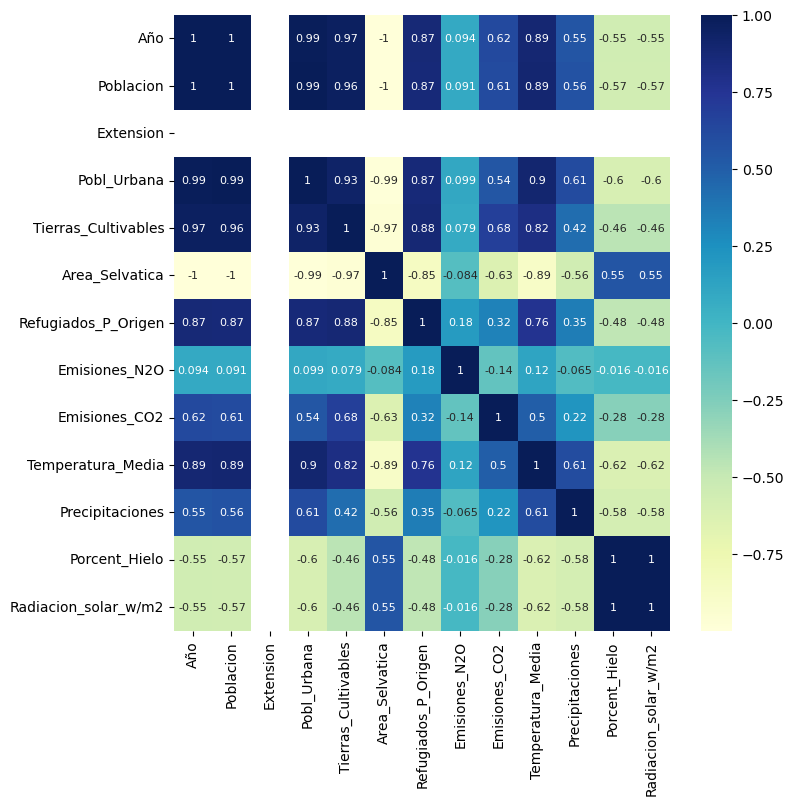

In [10]:
plt.subplots(figsize=(8,8))
sns.heatmap(tabla_reducida.corr(numeric_only = True),cmap = 'YlGnBu',annot = True, annot_kws = {"size": 8});

In [11]:
# Aplicamos test de Shapiro-Wilk para comprobar la normalidad de las variables:

from scipy.stats import shapiro

columnas_a_probar = [i for i in tabla_reducida.columns]

Probablemente_Gaussiana = []
Probablemente_NO_Gaussiana = []

for i in columnas_a_probar:
    data = tabla_reducida[i]
    print(i)
    stat, p = shapiro(data)
    print('stat=%.3f, p=%.3f' % (stat, p))
    
    if p > 0.05:
        print('Probablemente sea Gaussiana')
        Probablemente_Gaussiana.append(i)
    else:
        print('Probablemente NO sea Gaussiana')
        Probablemente_NO_Gaussiana.append(i)


Año
stat=0.955, p=0.021
Probablemente NO sea Gaussiana
Poblacion
stat=0.946, p=0.008
Probablemente NO sea Gaussiana
Extension
stat=1.000, p=1.000
Probablemente sea Gaussiana
Pobl_Urbana
stat=0.933, p=0.002
Probablemente NO sea Gaussiana
Tierras_Cultivables
stat=0.898, p=0.000
Probablemente NO sea Gaussiana
Area_Selvatica
stat=0.945, p=0.007
Probablemente NO sea Gaussiana
Refugiados_P_Origen
stat=0.915, p=0.000
Probablemente NO sea Gaussiana
Emisiones_N2O
stat=0.842, p=0.000
Probablemente NO sea Gaussiana
Emisiones_CO2
stat=0.962, p=0.046
Probablemente NO sea Gaussiana
Temperatura_Media
stat=0.968, p=0.091
Probablemente sea Gaussiana
Precipitaciones
stat=0.988, p=0.797
Probablemente sea Gaussiana
Porcent_Hielo
stat=0.985, p=0.654
Probablemente sea Gaussiana
Radiacion_solar_w/m2
stat=0.985, p=0.654
Probablemente sea Gaussiana


/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_morestats.py:1797: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "


In [12]:
print('Gaussiana: ', Probablemente_Gaussiana)
print('No Gaussiana: ', Probablemente_NO_Gaussiana)

Gaussiana:  ['Extension', 'Temperatura_Media', 'Precipitaciones', 'Porcent_Hielo', 'Radiacion_solar_w/m2']
No Gaussiana:  ['Año', 'Poblacion', 'Pobl_Urbana', 'Tierras_Cultivables', 'Area_Selvatica', 'Refugiados_P_Origen', 'Emisiones_N2O', 'Emisiones_CO2']


En estas condiciones, aplicaremos:  

- **RobustScaler:** Cuando las variables contienen outliers, sean Gaussianas o no. Escala las características utilizando estadísticas resistentes a los valores atípicos:  
- **MinMax:** Cuando son variables NO Gaussianas pero sin outliers.  
- **StandardScaler:** Cuando sigue una distribución Normal. Transforma de manera que tengan una media de 0 y una desviacion estándar de 1:

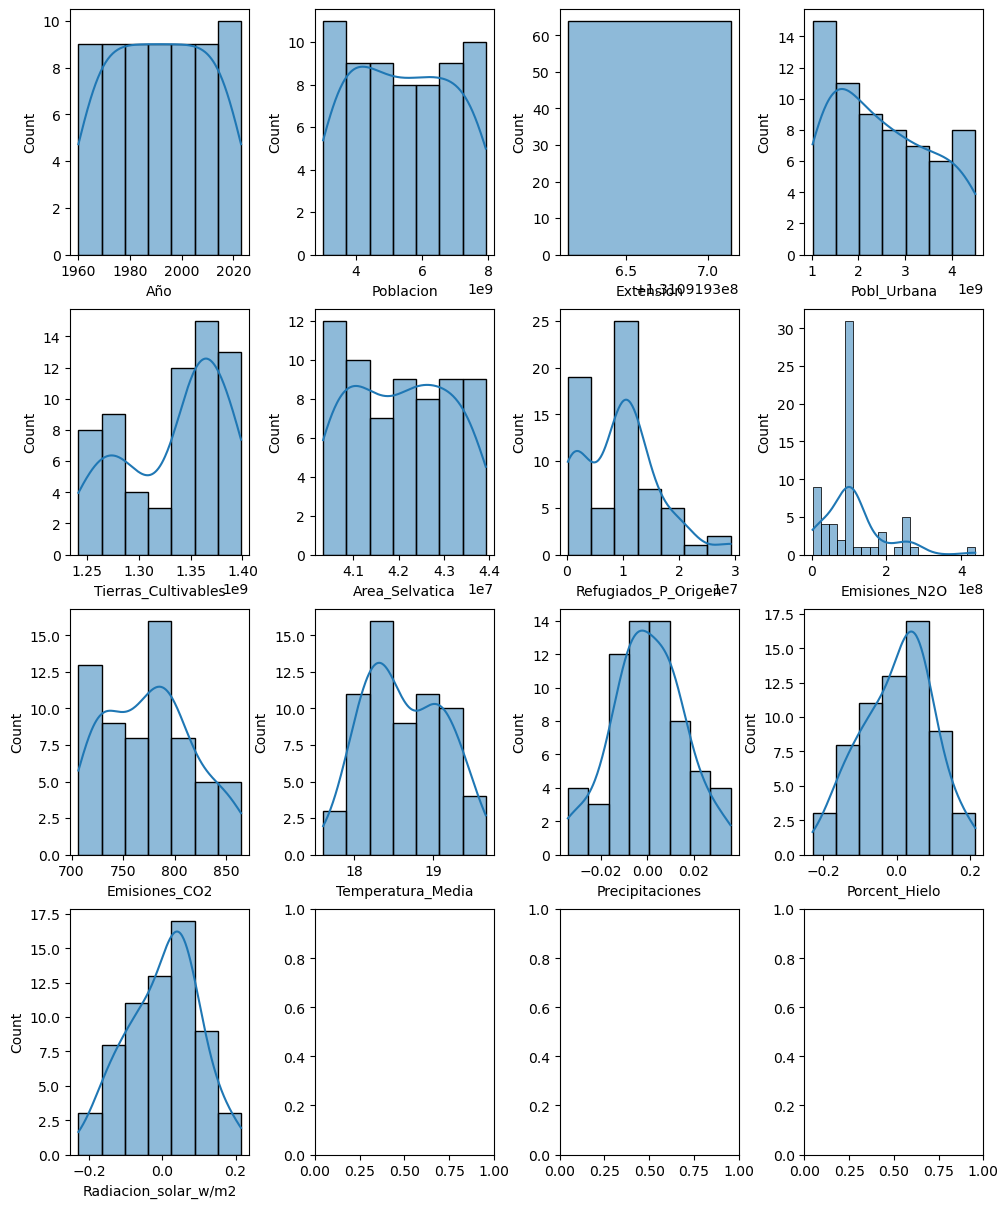

In [13]:
# Muestra gráfico de las variables

fig, axs = plt.subplots(ncols=4, nrows=4, figsize=(10,12))
index = 0
axs = axs.flatten()
for k,v in tabla_reducida[columnas_a_probar].items():
    sns.histplot(v, ax=axs[index], kde = True)
    index += 1
plt.tight_layout(pad=0.4)

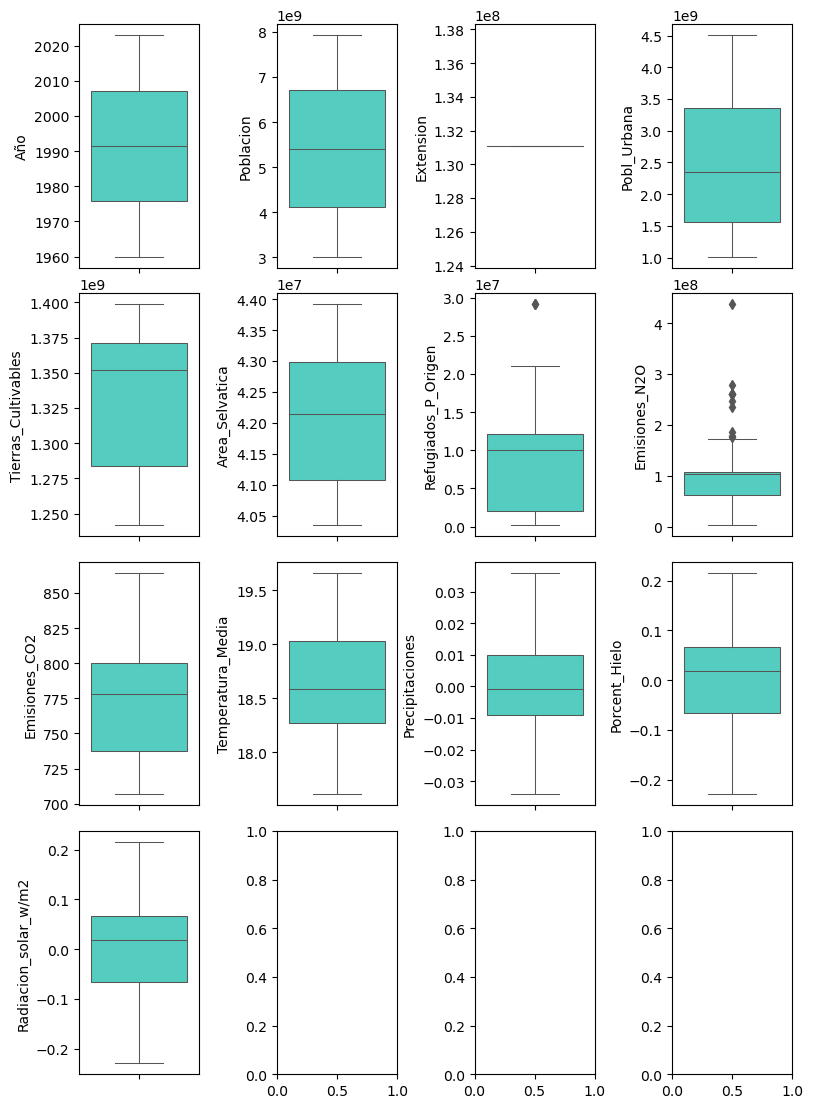

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# Representar gráficamente las distintas variables para ver su distribución y outliers
fig, axs = plt.subplots(ncols=4, nrows=4, figsize=(8, 11))
index = 0
axs = axs.flatten()

for k, v in tabla_reducida[columnas_a_probar].items():
    sns.boxplot(y=k, data=tabla_reducida, ax=axs[index], color='turquoise', linewidth= 0.75)
    index += 1

plt.style.use('ggplot')

plt.tight_layout(pad=0.4)
plt.show()


In [15]:
print('Gaussiana: ', Probablemente_Gaussiana)
print('No Gaussiana: ', Probablemente_NO_Gaussiana)

Gaussiana:  ['Extension', 'Temperatura_Media', 'Precipitaciones', 'Porcent_Hielo', 'Radiacion_solar_w/m2']
No Gaussiana:  ['Año', 'Poblacion', 'Pobl_Urbana', 'Tierras_Cultivables', 'Area_Selvatica', 'Refugiados_P_Origen', 'Emisiones_N2O', 'Emisiones_CO2']


En estas condiciones, aplicaremos:  

- **RobustScaler:** Cuando las variables contienen outliers, sean Gaussianas o no. Escala las características utilizando estadísticas resistentes a los valores atípicos:  
- **MinMax:** Cuando son variables NO Gaussianas pero sin outliers.  
- **StandardScaler:** Cuando sigue una distribución Normal. Transforma de manera que tengan una media de 0 y una desviacion estándar de 1:

In [16]:
# Hacemos una copia del dataframe para proceder al escalado de las variables.
tabla_proces = tabla_reducida.copy()

In [17]:
# Aplicamos StandardScaler:

Estandar = ['Extension', 'Precipitaciones', 'Porcent_Hielo','Radiacion_solar_w/m2']
scaler = preprocessing.StandardScaler().fit(tabla_reducida[Estandar])
tabla_proces[Estandar] = scaler.transform(tabla_reducida[Estandar])

In [18]:
# Aplicamos RobustScaler:

Robust = ['Refugiados_P_Origen', 'Emisiones_N2O']
scaler2 = preprocessing.RobustScaler().fit(tabla_reducida[Robust])
tabla_proces[Robust] = scaler2.transform(tabla_reducida[Robust])

In [19]:
# aplicamos MinMax:

Min_Max = ['Poblacion', 'Pobl_Urbana', 'Tierras_Cultivables', 'Area_Selvatica', 'Emisiones_CO2']
scaler3 = preprocessing.MinMaxScaler().fit(tabla_reducida[Min_Max])
tabla_proces[Min_Max] = scaler3.transform(tabla_reducida[Min_Max])

In [20]:
tabla_proces.head()

,Año,Poblacion,Extension,Pobl_Urbana,Tierras_Cultivables,Area_Selvatica,Refugiados_P_Origen,Emisiones_N2O,Emisiones_CO2,Temperatura_Media,Precipitaciones,Porcent_Hielo,Radiacion_solar_w/m2
0,1960,0.00,0.00,0.00,0.00,1.00,-0.98,-0.05,0.00,18.08,0.73,0.47,0.47
1,1961,0.01,0.00,0.01,0.00,0.98,-0.97,-0.05,0.02,18.22,0.56,-0.92,-0.92
2,1962,0.02,0.00,0.02,0.01,0.97,-0.96,-0.04,0.03,18.31,-0.41,-1.20,-1.20
3,1963,0.03,0.00,0.03,0.05,0.95,-0.96,-0.04,0.05,18.36,1.21,-0.25,-0.25
4,1964,0.05,0.00,0.04,0.07,0.93,-0.83,-0.03,0.07,17.99,-0.63,0.49,0.49


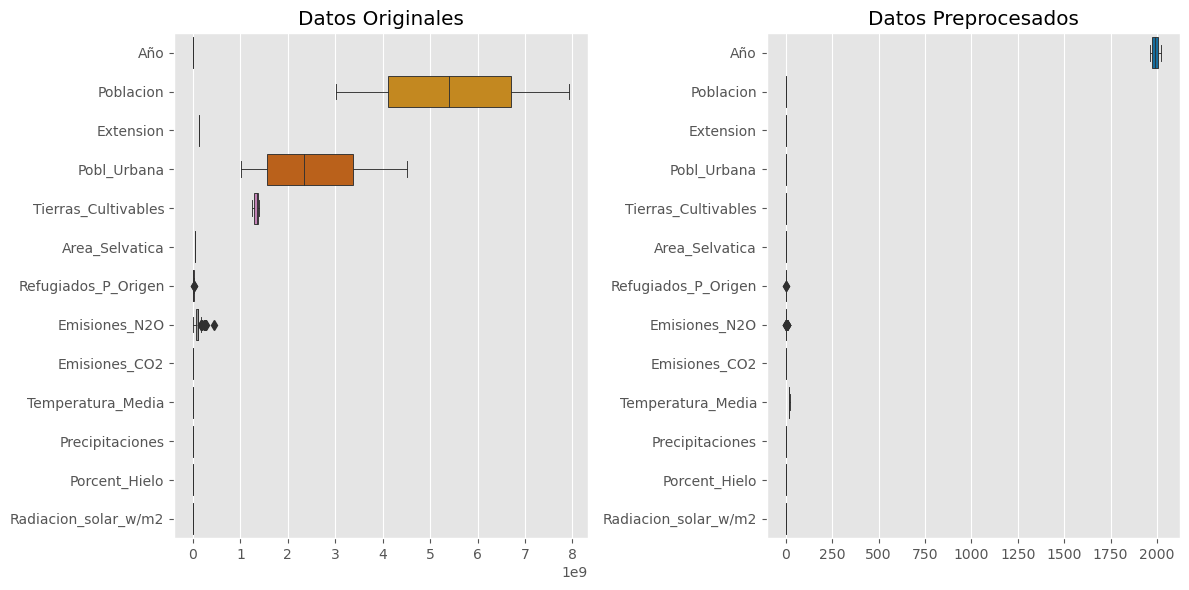

In [21]:
# Comparación datos originales / datos preprocesados

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Dataset original
sns.boxplot(data=tabla_reducida, ax=axes[0], palette='colorblind', orient = 'h',linewidth= 0.65)
axes[0].set_title('Datos Originales')

# Dataset Preprocesado
sns.boxplot(data=tabla_proces, ax=axes[1], palette='colorblind', orient = 'h', linewidth= 0.65)
axes[1].set_title('Datos Preprocesados')

plt.style.use('ggplot')

plt.tight_layout()
plt.show()

### **Modelo Ridge para Temperatura_Media**

In [22]:
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

X = tabla_proces[['Año','Poblacion','Extension', 'Pobl_Urbana', 'Tierras_Cultivables', 'Area_Selvatica', 'Refugiados_P_Origen', 'Emisiones_N2O', 'Emisiones_CO2', 'Precipitaciones', 'Porcent_Hielo', 'Radiacion_solar_w/m2']]
y = tabla_proces[['Temperatura_Media']]

# Define el rango de valores de alpha que deseas probar
param_grid = {'alpha': [0.1, 1.0, 10.0, 100.0, 500.00, 1000.00, 1100.00]}

# Crea un modelo de regresión Ridge
ridge = Ridge()

# Crea un objeto GridSearchCV para realizar la búsqueda de cuadrícula
grid_search = GridSearchCV(ridge, param_grid, cv=7)  # cv=5: validación cruzada de 5 divisiones

# Ajusta el modelo en los datos
grid_search.fit(X, y)

# Busca el mejor valor de alpha
best_alpha = grid_search.best_params_['alpha']

# El mejor modelo con el mejor alpha ya ha sido ajustado automáticamente
# Se accede al mejor modelo con: grid_search.best_estimator_

# hace predicciones en datos de prueba
y_pred = grid_search.predict(X)

# Calcular la precisión para cada salida y la media de todas las salidas.
# precision_train = modelo_multioutput_Ridge.score(X2_train, y2_train)
# precision_test = modelo_multioutput_Ridge.score(X2_test, y2_test)

precision_global = r2_score(y, y_pred)

# Imprime la precisión

print('La precisión global del modelo con Ridge es: {:.2f}%'.format(precision_global * 100))
print(grid_search.best_estimator_)

La precisión global del modelo con Ridge es: 80.96%
Ridge(alpha=100.0)


In [23]:
y_pred = pd.DataFrame(y_pred)
y_pred.columns = y.columns.copy()
y_pred.head()

,Temperatura_Media
0,17.95
1,18.02
2,18.04
3,18.05
4,18.01


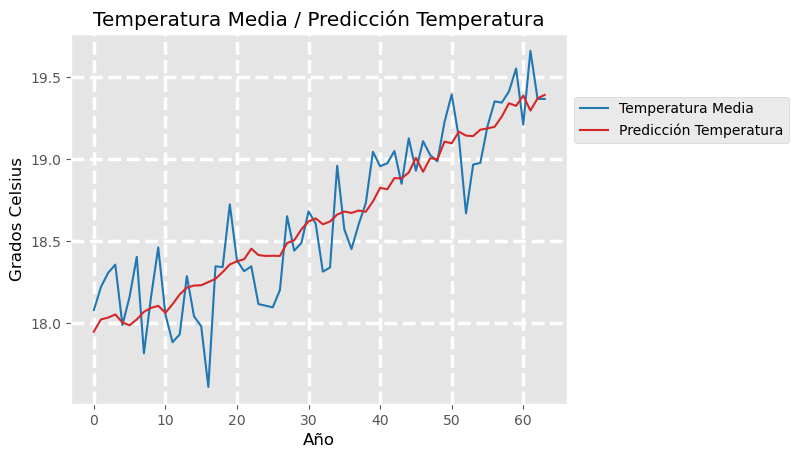

In [24]:
import pandas as pd
import matplotlib.pyplot as plt

# Crear una figura y ejes
fig, ax1 = plt.subplots()
color2 = 'black'
# Configurar el eje X (año)
ax1.set_xlabel('Año', color=color2)

# Configurar el primer eje (escala izquierda) para "Temperatura_Media"
color1 = 'tab:blue'
color2 = 'black'
ax1.set_ylabel('Grados Celsius', color=color2)
ax1.plot(tabla_proces.index, tabla_proces['Temperatura_Media'], color=color1)

# Configurar el segundo eje (escala izquierda) para "Predicción Temperatura"
color3 = 'tab:red'
ax1.plot(y_pred.index, y_pred, color=color3)

# Agregar título y leyendas
plt.title('Temperatura Media / Predicción Temperatura')
ax1.legend(['Temperatura Media', 'Predicción Temperatura'], loc='upper left', bbox_to_anchor=(1, 0.85))

plt.style.use('fivethirtyeight')
ax1.grid(color='white', linestyle='--', linewidth= 2.5)

# Mostrar el gráfico
plt.show()



In [25]:
# Datos prevision Población Mundial ONU.

pob_onu = pd.read_csv('previson_poblacion_mundial.csv')
poblacion_onu = pd.DataFrame(pob_onu)

poblacion_onu['Año'] = poblacion_onu['2023']
poblacion_onu['Poblacion'] = poblacion_onu['8045311']
poblacion_onu = poblacion_onu.drop(['2023', '8045311'], axis=1)
poblacion_onu['Poblacion'] = (poblacion_onu['Poblacion'] * 1000).copy()

poblacion_onu.head()

,Año,Poblacion
0,2024,8118836000
1,2025,8191988000
2,2026,8264365000
3,2027,8335978000
4,2028,8406829000


In [26]:
# Datos futuros de Año / Variables 

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge


# Datos históricos de población
hist_poblacion = tabla_reducida[['Año', 'Poblacion']]
hist_pob_urb = tabla_reducida[['Año', 'Pobl_Urbana']]
hist_t_cultiv = tabla_reducida[['Año', 'Tierras_Cultivables']]
hist_a_selv = tabla_reducida[['Año', 'Area_Selvatica']]
hist_ref_orig = tabla_reducida[['Año', 'Refugiados_P_Origen']]
hist_N2O = tabla_reducida[['Año', 'Emisiones_N2O']]
hist_CO2 = tabla_reducida[['Año', 'Emisiones_CO2']]
hist_precip = tabla_reducida[['Año', 'Precipitaciones']]
hist_hielo = tabla_reducida[['Año', 'Porcent_Hielo']]
hist_rad_sol = tabla_reducida[['Año', 'Radiacion_solar_w/m2']]

hist_extension = tabla_reducida[['Año', 'Extension']]
hist_temp_media = tabla_reducida[['Año', 'Temperatura_Media']]

# Modelo Ridge de regresión lineal

alpha = 1.0  # Ajustable

model_fut_pob = Ridge(alpha=alpha)
model_fut_pob_urb = Ridge(alpha=alpha)
model_fut_t_cultiv = Ridge(alpha=alpha)
model_fut_a_selv = Ridge(alpha=alpha)
model_fut_ref_orig = Ridge(alpha=alpha)
model_fut_N2O = Ridge(alpha=alpha)
model_fut_CO2 = Ridge(alpha=alpha)
model_fut_precip = Ridge(alpha=alpha)
model_fut_hielo = Ridge(alpha=alpha)
model_fut_rad_sol = Ridge(alpha=alpha)

model_fut_ext = Ridge(alpha = alpha)
model_fut_temp_media = Ridge(alpha = alpha)

# Ajusta el modelo a los datos históricos


A = hist_poblacion[['Año']]

b = hist_poblacion['Poblacion']
model_fut_pob.fit(A, b)

c = hist_pob_urb['Pobl_Urbana']
model_fut_pob_urb.fit(A, c)

d = hist_t_cultiv['Tierras_Cultivables']
model_fut_t_cultiv.fit(A, d)

e = hist_a_selv['Area_Selvatica']
model_fut_a_selv.fit(A, e)

f = hist_ref_orig['Refugiados_P_Origen']
model_fut_ref_orig.fit(A, f)

g = hist_N2O['Emisiones_N2O']
model_fut_N2O.fit(A, g)

h = hist_CO2['Emisiones_CO2']
model_fut_CO2.fit(A, h)

i = hist_precip['Precipitaciones']
model_fut_precip.fit(A, i)

j = hist_hielo['Porcent_Hielo']
model_fut_hielo.fit(A, j)

k = hist_rad_sol['Radiacion_solar_w/m2']
model_fut_rad_sol.fit(A, k)


bex = hist_extension['Extension']
model_fut_ext.fit(A, bex)

l = hist_temp_media['Temperatura_Media']
model_fut_temp_media.fit(A, l)


# Proyecta la población futura 
fut_años = np.arange(2024, 2051).astype(int)

fut_poblacion = model_fut_pob.predict(fut_años.reshape(-1, 1))
fut_pob_urb = model_fut_pob_urb.predict(fut_años.reshape(-1, 1))
fut_t_cultiv = model_fut_t_cultiv.predict(fut_años.reshape(-1, 1))
fut_a_selv = model_fut_a_selv.predict(fut_años.reshape(-1, 1))
fut_ref_orig = model_fut_ref_orig.predict(fut_años.reshape(-1, 1))
fut_N2O = model_fut_N2O.predict(fut_años.reshape(-1, 1))
fut_CO2 = model_fut_CO2.predict(fut_años.reshape(-1, 1))
fut_precip = model_fut_precip.predict(fut_años.reshape(-1, 1))
fut_hielo = model_fut_hielo.predict(fut_años.reshape(-1, 1))
fut_rad_sol = model_fut_rad_sol.predict(fut_años.reshape(-1, 1))

fut_ext = model_fut_ext.predict(fut_años.reshape(-1,1))
fut_temp_media = model_fut_temp_media.predict(fut_años.reshape(-1, 1))

# Crea un DataFrame para los datos proyectados
datos_proyectados = pd.DataFrame({
    'Año': fut_años,
    'Poblacion': poblacion_onu['Poblacion'],
    'Extension': fut_ext,
    'Pobl_Urbana': fut_pob_urb,
    'Tierras_Cultivables': fut_t_cultiv,
    'Area_Selvatica': fut_a_selv,
    'Refugiados_P_Origen': fut_ref_orig,
    'Emisiones_N2O': fut_N2O,
    'Emisiones_CO2': fut_CO2,
    'Temperatura_Media': fut_temp_media,
    'Precipitaciones': fut_precip,
    'Porcent_Hielo': fut_hielo,
    'Radiacion_solar_w/m2': fut_rad_sol
})

datos_proyectados.head()

/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Ridge was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Ridge was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Ridge was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Ridge was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Ridge was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Ridge was fitted with featu

,Año,Poblacion,Extension,Pobl_Urbana,Tierras_Cultivables,Area_Selvatica,Refugiados_P_Origen,Emisiones_N2O,Emisiones_CO2,Temperatura_Media,Precipitaciones,Porcent_Hielo,Radiacion_solar_w/m2
0,2024,8118836000,131091936.64,4358361535.95,1418118842.26,40121070.78,19709067.83,123672195.46,821.43,19.40,0.02,-0.09,-0.09
1,2025,8191988000,131091936.64,4415332528.31,1420679172.86,40061798.42,20028340.30,124077897.53,822.85,19.42,0.02,-0.09,-0.09
2,2026,8264365000,131091936.64,4472303520.68,1423239503.45,40002526.06,20347612.76,124483599.61,824.27,19.45,0.02,-0.10,-0.10
3,2027,8335978000,131091936.64,4529274513.04,1425799834.05,39943253.70,20666885.22,124889301.69,825.70,19.47,0.02,-0.10,-0.10
4,2028,8406829000,131091936.64,4586245505.41,1428360164.64,39883981.34,20986157.69,125295003.76,827.12,19.49,0.02,-0.10,-0.10


In [27]:
# Aplicamos test de Shapiro-Wilk para comprobar la normalidad de los datos_proyectados:

from scipy.stats import shapiro

columnas_a_probar = [i for i in datos_proyectados.columns]

Probablemente_Gaussiana2 = []
Probablemente_NO_Gaussiana2 = []

for i in columnas_a_probar:
    data = datos_proyectados[i]
    print(i)
    stat, p = shapiro(data)
    print('stat=%.3f, p=%.3f' % (stat, p))
    
    if p > 0.05:
        print('Probablemente sea Gaussiana')
        Probablemente_Gaussiana2.append(i)
    else:
        print('Probablemente NO sea Gaussiana')
        Probablemente_NO_Gaussiana2.append(i)

Año
stat=0.958, p=0.334
Probablemente sea Gaussiana
Poblacion
stat=0.953, p=0.247
Probablemente sea Gaussiana
Extension
stat=1.000, p=1.000
Probablemente sea Gaussiana
Pobl_Urbana
stat=0.958, p=0.334
Probablemente sea Gaussiana
Tierras_Cultivables
stat=0.958, p=0.334
Probablemente sea Gaussiana
Area_Selvatica
stat=0.958, p=0.334
Probablemente sea Gaussiana
Refugiados_P_Origen
stat=0.958, p=0.334
Probablemente sea Gaussiana
Emisiones_N2O
stat=0.958, p=0.334
Probablemente sea Gaussiana
Emisiones_CO2
stat=0.958, p=0.334
Probablemente sea Gaussiana
Temperatura_Media
stat=0.958, p=0.334
Probablemente sea Gaussiana
Precipitaciones
stat=0.958, p=0.334
Probablemente sea Gaussiana
Porcent_Hielo
stat=0.958, p=0.334
Probablemente sea Gaussiana
Radiacion_solar_w/m2
stat=0.958, p=0.334
Probablemente sea Gaussiana


/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_morestats.py:1797: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "


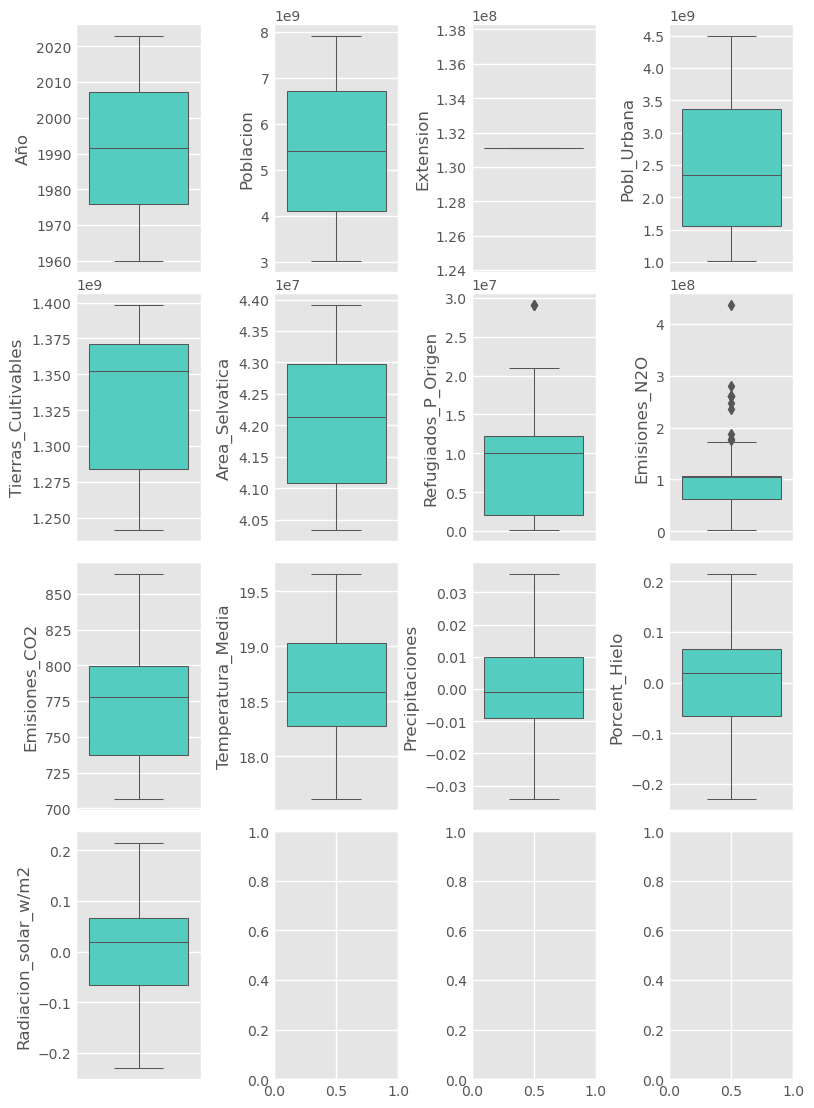

In [30]:
# Representamos gráficamente los datos_proyectados para ver su distribución, presencia / ausencia de outliers..

fig, axs = plt.subplots(ncols=4, nrows=4, figsize=(8, 11))
index = 0
axs = axs.flatten()
for k,v in datos_proyectados[columnas_a_probar].items():

    sns.boxplot(y=k, data=tabla_reducida, ax=axs[index], color='turquoise', linewidth= 0.75)
    index += 1

plt.style.use('ggplot')

plt.tight_layout(pad=0.4)
plt.show()


In [31]:
# Hacemos una copia del dataframe para proceder al escalado de las variables Proyectadas.
datos_proyectados_proces = datos_proyectados.copy()

# Aplicamos StandardScaler:

Estandar_proy = ['Extension', 'Precipitaciones', 'Porcent_Hielo','Radiacion_solar_w/m2']
scaler_proy = preprocessing.StandardScaler().fit(datos_proyectados[Estandar_proy])
datos_proyectados_proces[Estandar_proy] = scaler_proy.transform(datos_proyectados[Estandar_proy])

# Aplicamos RobustScaler:

Robust_proy = ['Refugiados_P_Origen', 'Emisiones_N2O']
scaler_proy2 = preprocessing.RobustScaler().fit(datos_proyectados[Robust_proy])
datos_proyectados_proces[Robust_proy] = scaler_proy2.transform(datos_proyectados[Robust_proy])

# aplicamos MinMax:

Min_Max_proy = ['Poblacion', 'Pobl_Urbana', 'Tierras_Cultivables', 'Area_Selvatica', 'Emisiones_CO2']
scaler_proy3 = preprocessing.MinMaxScaler().fit(datos_proyectados[Min_Max_proy])
datos_proyectados_proces[Min_Max_proy] = scaler_proy3.transform(datos_proyectados[Min_Max_proy])

datos_proyectados_proces.head()

,Año,Poblacion,Extension,Pobl_Urbana,Tierras_Cultivables,Area_Selvatica,Refugiados_P_Origen,Emisiones_N2O,Emisiones_CO2,Temperatura_Media,Precipitaciones,Porcent_Hielo,Radiacion_solar_w/m2
0,2024,0.00,0.00,0.00,0.00,1.00,-1.00,-1.00,0.00,19.40,-1.67,1.67,1.67
1,2025,0.05,0.00,0.04,0.04,0.96,-0.92,-0.92,0.04,19.42,-1.54,1.54,1.54
2,2026,0.09,0.00,0.08,0.08,0.92,-0.85,-0.85,0.08,19.45,-1.41,1.41,1.41
3,2027,0.14,0.00,0.12,0.12,0.88,-0.77,-0.77,0.12,19.47,-1.28,1.28,1.28
4,2028,0.18,0.00,0.15,0.15,0.85,-0.69,-0.69,0.15,19.49,-1.16,1.16,1.16


### **Aplicamos Modelo Ridge de Temperatura_Media a los datos futuros**

In [32]:
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

X2 = datos_proyectados_proces[['Año','Poblacion','Extension', 'Pobl_Urbana', 'Tierras_Cultivables', 'Refugiados_P_Origen', 'Emisiones_N2O', 'Emisiones_CO2', 'Temperatura_Media', 'Precipitaciones', 'Porcent_Hielo', 'Radiacion_solar_w/m2']]

y_pred_fut = grid_search.predict(X2)


/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- Temperatura_Media
Feature names seen at fit time, yet now missing:
- Area_Selvatica

  warnings.warn(message, FutureWarning)


In [33]:
temperatura_proyectada1 = pd.DataFrame()
temperatura_proyectada1['Año'] = tabla_reducida['Año']
temperatura_proyectada1['Temperatura_Media'] = tabla_reducida['Temperatura_Media']

temperatura_proyectada2 = pd.DataFrame()
temperatura_proyectada2['Año'] = datos_proyectados['Año']
temperatura_proyectada2['Temperatura_Media'] = y_pred_fut

temperatura_proyectada = pd.concat([temperatura_proyectada1, temperatura_proyectada2])

temperatura_proyectada.head()

,Año,Temperatura_Media
0,1960,18.08
1,1961,18.22
2,1962,18.31
3,1963,18.36
4,1964,17.99


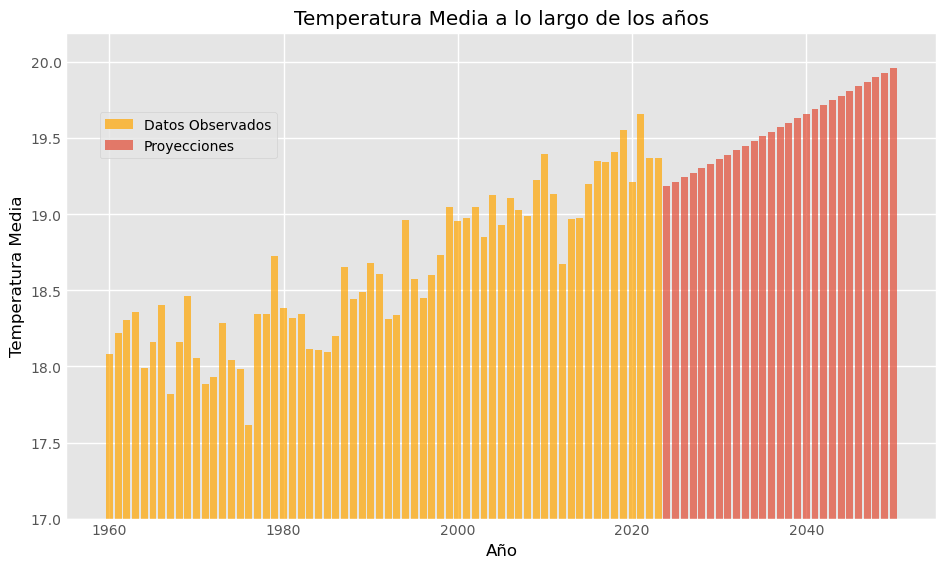

In [34]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))  # Tamaño de la figura

# Datos observados
datos_observados = temperatura_proyectada1
# Proyecciones
proyecciones = temperatura_proyectada2

# Calcula el rango centrado en los valores de ambas series de datos
min_valor = min(datos_observados['Temperatura_Media'].min(), proyecciones['Temperatura_Media'].min())
max_valor = max(datos_observados['Temperatura_Media'].max(), proyecciones['Temperatura_Media'].max())
rango = max_valor - min_valor
margen = rango * 0.1  # Ajusta el margen como un porcentaje del rango
rango_min = min_valor - margen
rango_max = max_valor + margen

# Crea un gráfico de barras para los datos observados
plt.bar(datos_observados['Año'], datos_observados['Temperatura_Media'], label='Datos Observados', alpha=0.7, color = 'orange')

# Crea un gráfico de barras para las proyecciones
plt.bar(proyecciones['Año'], proyecciones['Temperatura_Media'], label='Proyecciones', alpha=0.7)

plt.xlabel('Año', color = 'black')
plt.ylabel('Temperatura Media', color = 'black')
plt.title('Temperatura Media a lo largo de los años', color = 'black')
plt.legend(bbox_to_anchor=(0.25, 0.85))  # Agregar una leyenda

# Configura el rango del eje Y
plt.ylim(17, rango_max)

plt.grid(True)
plt.show()


## Cambiamos los escenarios para ver la evolución de la temperatura

In [35]:
# Copia los datos originales para no modificar los originales
proyecciones_modificadas = datos_proyectados.copy()


factores = {
    'Año': 1 ,
    'Poblacion': 1,
    'Extension': 1,
    'Pobl_Urbana': 1,
    'Tierras_Cultivables': 1,
    'Area_Selvatica': 1,
    'Refugiados_P_Origen': 1,
    'Emisiones_N2O': 1,
    'Emisiones_CO2': 1,
    'Precipitaciones': 1,
    'Porcent_Hielo': 1,
    'Radiacion_solar_w/m2': 1
}


# Define la función para calcular la temperatura promedio en todos los años
def calcular_temperatura_promedio(proyecciones, factores):
    # Aplicar los factores a las proyecciones
    for fila in range(1, len(proyecciones)):
        for columna, factor_corrector in factores.items():
            if factor_corrector != 1:
                proyecciones.loc[fila, columna] = proyecciones.loc[fila - 1, columna] * factor_corrector
    # Calcular la temperatura promedio en todos los años
    temperatura_promedio = proyecciones['Temperatura_Media'].mean()
    return temperatura_promedio

# Inicializa los factores con los valores actuales
factores_actuales = factores.copy()

# Define un factor de degradación para todas las variables excepto Temperatura_Media, Año y Extension
factor_degradacion = 0.99  # Valor menor que 1 para una tendencia a la baja

# Realiza un bucle para ajustar los factores y degradar todas las variables excepto Temperatura_Media, Año y Extension
for fila in range(1, len(proyecciones_modificadas)):
    for columna, factor_corrector in factores_actuales.items():
        if columna not in ['Temperatura_Media', 'Año', 'Extension']:
            factores_actuales[columna] *= factor_degradacion
    temperatura_actual = calcular_temperatura_promedio(proyecciones_modificadas, factores_actuales)

# Imprime los factores que degradan todas las variables excepto Temperatura_Media, Año y Extension
factores_ajustados = {columna: factor_corrector for columna, factor_corrector in factores_actuales.items() if columna not in ['Temperatura_Media', 'Año', 'Extension']}
print("Factores que degradan todas las variables excepto Temperatura_Media, Año y Extension:")
print(factores_ajustados)


Factores que degradan todas las variables excepto Temperatura_Media, Año y Extension:
{'Poblacion': 0.7700431458051551, 'Pobl_Urbana': 0.7700431458051551, 'Tierras_Cultivables': 0.7700431458051551, 'Area_Selvatica': 0.7700431458051551, 'Refugiados_P_Origen': 0.7700431458051551, 'Emisiones_N2O': 0.7700431458051551, 'Emisiones_CO2': 0.7700431458051551, 'Precipitaciones': 0.7700431458051551, 'Porcent_Hielo': 0.7700431458051551, 'Radiacion_solar_w/m2': 0.7700431458051551}


In [36]:
proyecciones_escenarios = datos_proyectados.copy()
proyecciones_escenarios = proyecciones_escenarios.reset_index(drop=True)

# Define los factores de cambio independientes para cada variable
factores = {
    'Año': 1 ,
    'Poblacion': 0.95,
    'Extension': 1,
    'Pobl_Urbana': 0.7315409885148975,
    'Tierras_Cultivables': 0.7700431458051551,
    'Area_Selvatica': 0.8470474603856704,
    'Refugiados_P_Origen': 0.7700431458051551,
    'Emisiones_N2O': 0.7700431458051551,
    'Emisiones_CO2': 0.7700431458051551,
    'Precipitaciones': 0.7700431458051551,
    'Porcent_Hielo': 0.7700431458051551,
    'Radiacion_solar_w/m2': 0.7700431458051551
}


for fila in range(1, len(proyecciones_escenarios)):
    for columna, factor_corrector in factores.items():
        if factor_corrector == 1:
            proyecciones_escenarios.loc[fila, columna] = proyecciones_escenarios.loc[fila, columna]
        else:
            proyecciones_escenarios.loc[fila, columna] = proyecciones_escenarios.loc[fila - 1, columna] * factor_corrector

proyecciones_escenarios.head()

,Año,Poblacion,Extension,Pobl_Urbana,Tierras_Cultivables,Area_Selvatica,Refugiados_P_Origen,Emisiones_N2O,Emisiones_CO2,Temperatura_Media,Precipitaciones,Porcent_Hielo,Radiacion_solar_w/m2
0,2024,8118836000.00,131091936.64,4358361535.95,1418118842.26,40121070.78,19709067.83,123672195.46,821.43,19.40,0.02,-0.09,-0.09
1,2025,7712894200.00,131091936.64,3188320106.31,1092012694.42,33984451.12,15176832.60,95232926.44,632.54,19.42,0.01,-0.07,-0.07
2,2026,7327249490.00,131091936.64,2332386842.27,840896890.47,28786443.01,11686815.92,73333462.26,487.08,19.45,0.01,-0.05,-0.05
3,2027,6960887015.50,131091936.64,1706236576.20,647526886.84,24383483.45,8999352.49,56469929.97,375.08,19.47,0.01,-0.04,-0.04
4,2028,6612842664.72,131091936.64,1248181991.59,498623640.93,20653967.73,6929889.70,43484282.52,288.82,19.49,0.01,-0.03,-0.03


In [37]:
# Aplicamos test de Shapiro-Wilk para comprobar la normalidad de las proyecciones_escenarios:

from scipy.stats import shapiro

columnas_a_probar2 = [i for i in proyecciones_escenarios.columns]

Probablemente_Gaussiana3 = []
Probablemente_NO_Gaussiana3 = []

for i in columnas_a_probar2:
    data = proyecciones_escenarios[i]
    print(i)
    stat, p = shapiro(data)
    print('stat=%.3f, p=%.3f' % (stat, p))
    
    if p > 0.05:
        print('Probablemente sea Gaussiana')
        Probablemente_Gaussiana3.append(i)
    else:
        print('Probablemente NO sea Gaussiana')
        Probablemente_NO_Gaussiana3.append(i)


Año
stat=0.958, p=0.334
Probablemente sea Gaussiana
Poblacion
stat=0.936, p=0.097
Probablemente sea Gaussiana
Extension
stat=1.000, p=1.000
Probablemente sea Gaussiana
Pobl_Urbana
stat=0.621, p=0.000
Probablemente NO sea Gaussiana
Tierras_Cultivables
stat=0.673, p=0.000
Probablemente NO sea Gaussiana
Area_Selvatica
stat=0.793, p=0.000
Probablemente NO sea Gaussiana
Refugiados_P_Origen
stat=0.673, p=0.000
Probablemente NO sea Gaussiana
Emisiones_N2O
stat=0.673, p=0.000
Probablemente NO sea Gaussiana
Emisiones_CO2
stat=0.673, p=0.000
Probablemente NO sea Gaussiana
Temperatura_Media
stat=0.958, p=0.334
Probablemente sea Gaussiana
Precipitaciones
stat=0.673, p=0.000
Probablemente NO sea Gaussiana
Porcent_Hielo
stat=0.673, p=0.000
Probablemente NO sea Gaussiana
Radiacion_solar_w/m2
stat=0.673, p=0.000
Probablemente NO sea Gaussiana


/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_morestats.py:1797: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "


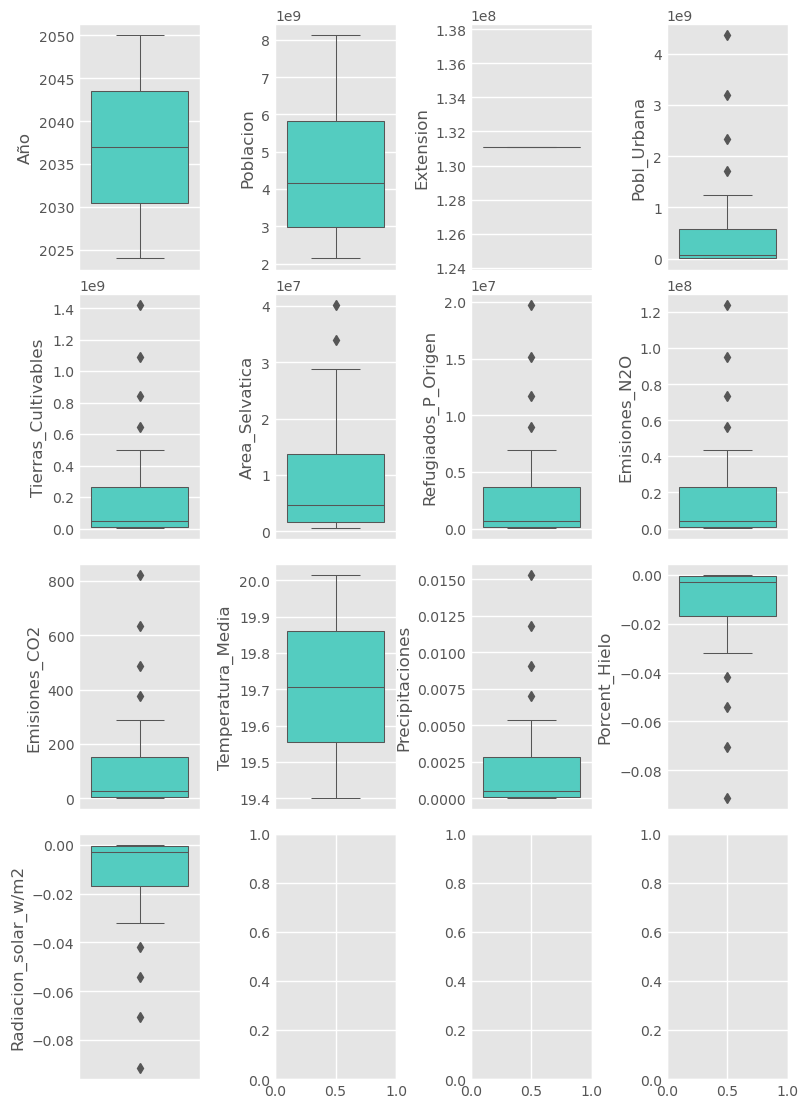

In [38]:
# Representamos gráficamente los proyecciones_escenarios para ver su distribución, presencia / ausencia de outliers..

fig, axs = plt.subplots(ncols=4, nrows=4, figsize=(8, 11))
index = 0
axs = axs.flatten()
for k,v in proyecciones_escenarios[columnas_a_probar].items():

#for k,v in df.items():
    sns.boxplot(y=k, data=proyecciones_escenarios, ax=axs[index], color = 'turquoise', linewidth= 0.75)
    index += 1

plt.style.use('ggplot')

plt.tight_layout(pad=0.4)
plt.show()


In [39]:
# Hacemos una copia del dataframe para proceder al escalado de las variables de proyecciones_escenarios

proyecciones_escenarios_proces = proyecciones_escenarios.copy()

# Aplicamos StandardScaler

Estandar_esc = ['Extension', 'Precipitaciones', 'Porcent_Hielo','Radiacion_solar_w/m2']
scaler_esc = preprocessing.StandardScaler().fit(proyecciones_escenarios[Estandar_esc])
proyecciones_escenarios_proces[Estandar_esc] = scaler_esc.transform(proyecciones_escenarios[Estandar_esc])

# Aplicamos RobustScaler
Robust_esc = ['Refugiados_P_Origen', 'Emisiones_N2O']
scaler_esc2 = preprocessing.RobustScaler().fit(proyecciones_escenarios[Robust_esc])
proyecciones_escenarios_proces[Robust_esc] = scaler_esc2.transform(proyecciones_escenarios[Robust_esc])

# Aplicamos MinMaxScaler
Min_Max_esc = ['Poblacion', 'Pobl_Urbana', 'Tierras_Cultivables', 'Area_Selvatica', 'Emisiones_CO2']
scaler_esc3 = preprocessing.MinMaxScaler().fit(proyecciones_escenarios[Min_Max_esc])
proyecciones_escenarios_proces[Min_Max_esc] = scaler_esc3.transform(proyecciones_escenarios[Min_Max_esc])

proyecciones_escenarios_proces.head()

,Año,Poblacion,Extension,Pobl_Urbana,Tierras_Cultivables,Area_Selvatica,Refugiados_P_Origen,Emisiones_N2O,Emisiones_CO2,Temperatura_Media,Precipitaciones,Porcent_Hielo,Radiacion_solar_w/m2
0,2024,1.00,0.00,1.00,1.00,1.00,5.42,5.42,1.00,19.40,3.29,-3.29,-3.29
1,2025,0.93,0.00,0.73,0.77,0.84,4.13,4.13,0.77,19.42,2.39,-2.39,-2.39
2,2026,0.87,0.00,0.54,0.59,0.71,3.14,3.14,0.59,19.45,1.69,-1.69,-1.69
3,2027,0.81,0.00,0.39,0.46,0.60,2.37,2.37,0.46,19.47,1.16,-1.16,-1.16
4,2028,0.75,0.00,0.29,0.35,0.51,1.78,1.78,0.35,19.49,0.75,-0.75,-0.75


### Predicciones temperatura con nuevos escenarios

In [40]:
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

X3 = proyecciones_escenarios_proces[['Año', 'Poblacion', 'Extension', 'Pobl_Urbana', 'Tierras_Cultivables', 'Area_Selvatica', 'Refugiados_P_Origen', 'Emisiones_N2O', 'Emisiones_CO2', 'Precipitaciones', 'Porcent_Hielo', 'Radiacion_solar_w/m2']]

y_pred_esc = grid_search.predict(X3)


In [41]:
y_pred_esc = pd.DataFrame(y_pred_esc)
y_pred_esc.columns = y.columns.copy()
y_pred_esc.head()

,Temperatura_Media
0,19.58
1,19.54
2,19.51
3,19.49
4,19.48


In [42]:
temperatura_escenario1= pd.DataFrame()
temperatura_escenario1['Año'] = tabla_reducida['Año']
temperatura_escenario1['Temperatura_Media'] = tabla_reducida['Temperatura_Media']

temperatura_escenario2 = pd.DataFrame()
temperatura_escenario2['Año'] = proyecciones_escenarios['Año']
temperatura_escenario2['Temperatura_Media'] = y_pred_esc

temperatura_escenario = pd.concat([temperatura_escenario1, temperatura_escenario2])

temperatura_escenario.head()

,Año,Temperatura_Media
0,1960,18.08
1,1961,18.22
2,1962,18.31
3,1963,18.36
4,1964,17.99


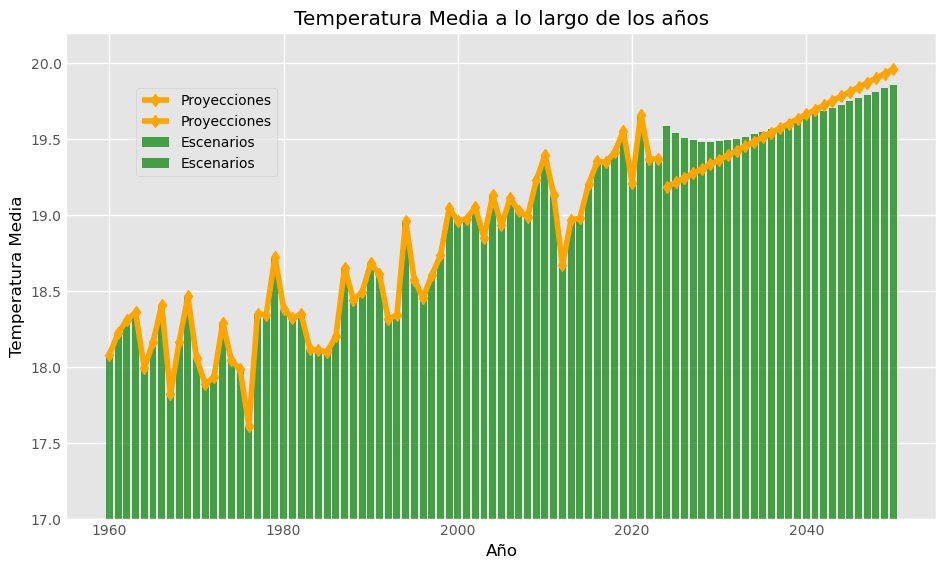

In [43]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

# Grafica los datos de temperatura_proyectada1
#plt.plot(temperatura_proyectada1['Año'], temperatura_proyectada1['Temperatura_Media'], label='Datos Observados', marker='o', linestyle='-')
#plt.plot(temperatura_escenario1['Año'], temperatura_escenario1['Temperatura_Media'], label='Datos Observados', marker='o', linestyle='-', color = 'orange')
plt.bar(temperatura_proyectada1['Año'], temperatura_proyectada1['Temperatura_Media'], label='Escenarios', alpha=0.7, color = 'green')
plt.plot(temperatura_proyectada1['Año'], temperatura_proyectada1['Temperatura_Media'], label='Proyecciones', marker='d', linestyle='-', color = 'orange')


# Graficar los datos de temperatura_proyectada2 (proyecciones)
plt.plot(temperatura_proyectada2['Año'], temperatura_proyectada2['Temperatura_Media'], label='Proyecciones', marker='d', linestyle='-', color = 'orange')
#plt.plot(temperatura_escenario2['Año'], temperatura_escenario2['Temperatura_Media'], label='Escenario', marker='o', linestyle='-', color = 'green')
plt.bar(temperatura_escenario2['Año'], temperatura_escenario2['Temperatura_Media'], label='Escenarios', alpha=0.7, color = 'green')

plt.xlabel('Año', color = 'black')
plt.ylabel('Temperatura Media', color = 'black')
plt.title('Temperatura Media a lo largo de los años', color = 'black')
plt.legend(bbox_to_anchor=(0.25, 0.90))

plt.ylim(17, 20.2)

plt.grid(True)
plt.show()


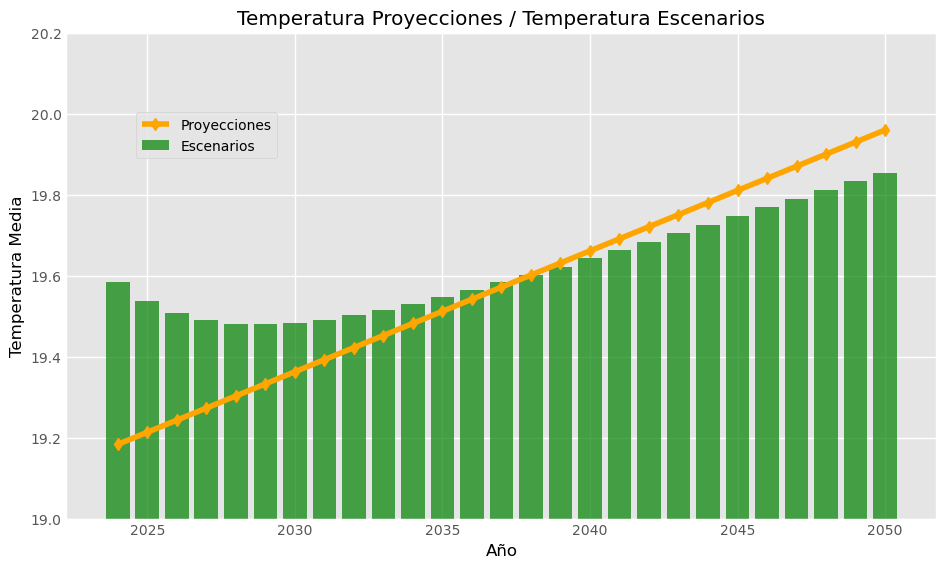

In [44]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

# Graficar los datos de temperatura_proyectada2 (proyecciones)
plt.plot(temperatura_proyectada2['Año'], temperatura_proyectada2['Temperatura_Media'], label='Proyecciones', marker='d', linestyle='-',color = 'orange' )
plt.bar(temperatura_escenario2['Año'], temperatura_escenario2['Temperatura_Media'], label='Escenarios', alpha=0.7, color = 'green')

plt.xlabel('Año', color = 'black')
plt.ylabel('Temperatura Media', color = 'black')
plt.title('Temperatura Proyecciones / Temperatura Escenarios', color = 'black')
plt.legend(bbox_to_anchor=(0.25, 0.85))

plt.ylim(19, 20.2)

plt.grid(True)
plt.show()


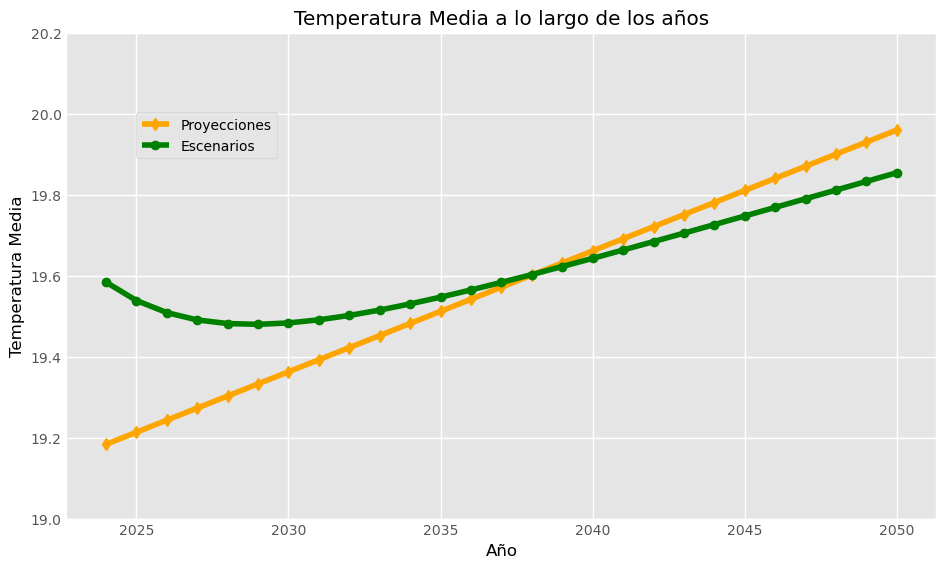

In [45]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

# Grafica los datos de temperatura_proyectada1
#plt.plot(temperatura_proyectada1['Año'], temperatura_proyectada1['Temperatura_Media'], label='Datos Observados', marker='o', linestyle='-')
#plt.plot(temperatura_escenario1['Año'], temperatura_escenario1['Temperatura_Media'], label='Datos Observados', marker='o', linestyle='-')

# Graficar los datos de temperatura_proyectada2 (proyecciones)
plt.plot(temperatura_proyectada2['Año'], temperatura_proyectada2['Temperatura_Media'], label='Proyecciones', marker='d', linestyle='-',color = 'orange' )
plt.plot(temperatura_escenario2['Año'], temperatura_escenario2['Temperatura_Media'], label='Escenarios', marker='o', linestyle='-', color = 'green')

plt.xlabel('Año', color = 'black')
plt.ylabel('Temperatura Media', color = 'black')
plt.title('Temperatura Media a lo largo de los años', color = 'black')
plt.legend(bbox_to_anchor=(0.25, 0.85))

plt.ylim(19, 20.2)  # Sustituye 10 y 22 con los valores deseados


plt.grid(True)
plt.show()
